# Analysing Covid Open data

Open data byt Finnish Institute for Health and Wellbeing can be found here:

https://thl.fi/fi/tilastot-ja-data/aineistot-ja-palvelut/avoin-data/varmistetut-koronatapaukset-suomessa-covid-19-

Dimensions available can be found here:

https://sampo.thl.fi/pivot/prod/fi/epirapo/covid19case/fact_epirapo_covid19case.dimensions.json

pyjstat is a python library for JSON-stat formatted data manipulation which allows reading and writing JSON-stat:

https://github.com/predicador37/pyjstat

jsonstat.py is a library for reading the JSON-stat data format maintained and promoted by Xavier Badosa. jsonstat.py library tries to mimic as much is possible in python the json-stat Javascript Toolkit. One of the library objectives is to be helpful in exploring dataset using jupyter (ipython) notebooks.

https://github.com/26fe/jsonstat.py

JSON-stat format definition can be found here

https://json-stat.org/format/



In [1]:
import math
import datetime

import requests
import json 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

import jsonstat

plt.rcParams['figure.figsize'] = (16, 9)

## First, request some data

Let's create a request for the date. We go for the following dimensions and measures:

**443702 - day level data:**

```
{
	"id":"dateweek2020010120201231",
	"label":"Aika",
	"children": [
{
...
{
	"id":"dateweek202001012020123155",
	"sid":443702,
	"label":"2020-01-01",
	"stage":"date",
	"code":"dateweek202001012020123155",
	"sort":55,
	"uri":"http://meta.thl.fi/codes/wild/dimension/dateweek2020010120201231/1/date/55",
	"children": []

},
```
**445222 - all areas:**
```
{
	"id":"hcdmunicipality2020",
	"label":"Alue",
	"children": [
{
	"id":"hcdmunicipality20201",
	"sid":445222,
	"label":"Kaikki Alueet",
	"stage":"root",
	"code":"hcdmunicipality20201",
	"sort":1,
	"uri":"http://meta.thl.fi/codes/wild/dimension/hcdmunicipality2020/1/root/1",
	"children": 
    
    
    }]},
``` 
**444833 - number of cases:**
``` 
{
	"id":"measure",
	"label":"Mittari",
	"children": [
{
	"id":"measure",
	"sid":141082,
	"label":"Mittarit",
	"stage":"root",
	"sort":1,
	"uri":"http://meta.thl.fi/codes/wild/measure/root/1/",
	"children": [
{
	"id":"measure/n_covid_ttr",
	"sid":444833,
	"label":"Tapausten lukumäärä",
	"stage":"leaf",
	"sort":3,
	"decimals":0,
	"uri":"http://meta.thl.fi/codes/wild/measure/n_covid_ttr/1/leaf",
	"properties": {
	"is":"measure/n_covid_ttr"
	},
	"children": []

}
``` 

## Update Dec 28, 2020

Hmmm....Previous query created some weeks ago, in early December no longer works. It seems that dimension names have changed, probably in preparation for the year 2021. The query for dimensions of the query above for dimensions `fact_epirapo_covid19case.dimensions.json` (still) returns dimensions that do not work. 

However, the Institute's open data pages refer to `dateweek20200101` instead of `dateweek2020010120201231`. The old `sid`s do not go well with the new dimensions. let's try this:

    dateweek2020010120201231-443702L -> dateweek20200101-508804L
    
Obviously, we need to clean references to `dateweek2020010120201231` in the code below as well

In [2]:
url = 'https://sampo.thl.fi/pivot/prod/fi/epirapo/covid19case/fact_epirapo_covid19case.json?'

# MOD Dec 28...this used to work, but no longer does
# url += 'row=dateweek2020010120201231-443702L&column=hcdmunicipality2020-445222&column=measure-444833'

url += 'row=dateweek20200101-508804L&column=hcdmunicipality2020-445222&column=measure-444833'

In [3]:
# returns 403 forbidden without headers, it seems User-Agent is enough, this copied from Chrome browser request

headers = {'Connection': 'keep-alive',
    'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Mobile Safari/537.36',
}

r = requests.get(url, headers=headers)

'HTTP Get request returned status code {}'.format(r.status_code)


'HTTP Get request returned status code 200'

## See the data in a browser tool

To verify that the request makes sense, it is possible to view the returned data cube in a browser tool by removing the `.json` part of the request. Click the link below.

It would also be possible to download the data in csv-format by changeing the extension to `.csv`. That would probably same some time and trouble, but we stick with json for now.

In [4]:
print(url.replace('.json',''))

https://sampo.thl.fi/pivot/prod/fi/epirapo/covid19case/fact_epirapo_covid19case?row=dateweek20200101-508804L&column=hcdmunicipality2020-445222&column=measure-444833


## Then, fix the data
Now that we have the data, we need to fix it...For some reason python JSON-stat parsers do not tolerate the format returned by the open data interface. So we need to do some fixes before proceeding...

### Remove the extra dataset layer
There is an extra `dataset` layer in the returned JSON:
```
{
  "dataset": {  
       "version": "2.0",  
       ...
```

As parsers do not understand the data, we need to remove the layer to get to this:
``` 
{
    "version": "2.0",
    ...
```
### Move id and size are not under root element

According to [JSON-stat format definition](https://json-stat.org/format/#id), `id` and `size` are expected under root element, like this:
```
{
   "version" : "2.0",
   "class" : "dataset",
   "id" : ["metric", "time", "geo", "sex"],
   "size" : [1, 1, 1, 3],
   …
}
```
The format returned has `id` and `size` under `dimension` for some reason, like this:
```
{
    "dataset": {
    "version": "2.0",
    "class": "dataset",
    "label": "Tartuntatautirekisterin COVID-19-tapaukset",
    "dimension": {
        "id": [
            "measure","dateweek20200101"
        ],
        "size": [
            1,54
        ],
```
### Sparse value object does not work
The two tested Python JSON-stat parsers do not understand sparse objects. [JSON stat format states](https://json-stat.org/format/#value):
> Value usually takes the form of an array where missing values are expressed as nulls. To avoid too many nulls, the value property can take the form of an object.
```
{
   "version" : "2.0",
   "class" : "dataset",
   "value" : { "0": 1.3587, "18": 1.5849 },
   …
}
```
So the object needs to be mapped to an array, following this example:

```
{
   "version" : "2.0",
   "class" : "dataset",
   "value" : [105.3, 104.3, null, 177.2, …],
   …
}
```

In [5]:
# do the cleaning steps discussed above
# format returned by the institute for Health and Wellfare labeled obnoxiously as 'faulty', we want to get to 'fixed'

faulty = r.json()

# first remove the extra 'dataset' layer from the response

fixed = faulty['dataset']

# move id and size to root

fixed['id'] = fixed['dimension']['id']
del fixed['dimension']['id']
fixed['size'] = fixed['dimension']['size']
del fixed['dimension']['size']

# map the sparse value object to an array

len = math.prod(fixed['size'])
f = [None] * len
v = fixed['value']
for index, value in zip(v.keys(), v.values()):
    f[int(index)] = int(value)
        
fixed['value'] = f
data_as_jsonstat = jsonstat.from_json(fixed)

## Get data to a Pandas DataFrame

Now that the data has ben healed, we can get the data into a Pandas DataFrame

In [6]:
meas_name = 'Tapausten lukumäärä'

# use jsonstat to transform to a dataframe

meas_index = data_as_jsonstat.dimension('measure').category(meas_name).index
df = data_as_jsonstat.to_data_frame(content='label', blocked_dims={'measure': meas_index})

# get the names for dimensions and use them as column names

colnames = [dim.did for dim in data_as_jsonstat.dimensions()]
colnames.append(df.columns.tolist()[-1]) 

df.columns = colnames
print("columns:",df.columns)

columns: Index(['dateweek20200101', 'hcdmunicipality2020', 'measure', 'Value'], dtype='object')


## Process the Dataframe

First, let's take a peek into the data frame to see what we got

In [7]:
df.iloc[3330:3340]

dateweek20200101     hcdmunicipality2020              measure  Value
3330       2020-05-31         Etelä-Savon SHP  Tapausten lukumäärä    0.0
3331       2020-05-31           Itä-Savon SHP  Tapausten lukumäärä    0.0
3332       2020-05-31    Pohjois-Karjalan SHP  Tapausten lukumäärä    0.0
3333       2020-05-31       Pohjois-Savon SHP  Tapausten lukumäärä    0.0
3334       2020-05-31        Keski-Suomen SHP  Tapausten lukumäärä    1.0
3335       2020-05-31    Etelä-Pohjanmaan SHP  Tapausten lukumäärä    0.0
3336       2020-05-31              Vaasan SHP  Tapausten lukumäärä    0.0
3337       2020-05-31    Keski-Pohjanmaan SHP  Tapausten lukumäärä    0.0
3338       2020-05-31  Pohjois-Pohjanmaan SHP  Tapausten lukumäärä    0.0
3339       2020-05-31             Kainuun SHP  Tapausten lukumäärä    0.0

Good, so let's create a time valued index and transform the data into a wide format

In [8]:
# get the dateweek values into time format, create a new column and drop the original one

df_dates = (
    df.assign(date = pd.to_datetime(df['dateweek20200101'], format='%Y-%m-%d'))
    .drop(columns=['dateweek20200101','measure'])

)

# Assume that if value is missing and some time has passed, like 20 days, there were no cases
# thus, we can substitute zeros for Nan. NaNs in the past days mean that the value is not yet available
  
past_limit = datetime.datetime.now() - datetime.timedelta(days = 20)

df.loc[ (df_dates['date'] < past_limit) & (df_dates['Value'].isna()), 'Value'] = 0

# transform into wider, tidyer format
# just drop the extra level of column headers

df_dates = (
    df_dates.set_index(['date', 'hcdmunicipality2020'])
    .unstack('hcdmunicipality2020')
    .droplevel(0,axis='columns')
)

Let's print out some more information about the dataframe

In [9]:
print (df_dates.dtypes)
print ("index is", df_dates.index)
print ("columns are", df_dates.columns)

hcdmunicipality2020
Ahvenanmaa                    float64
Etelä-Karjalan SHP            float64
Etelä-Pohjanmaan SHP          float64
Etelä-Savon SHP               float64
Helsingin ja Uudenmaan SHP    float64
Itä-Savon SHP                 float64
Kaikki Alueet                 float64
Kainuun SHP                   float64
Kanta-Hämeen SHP              float64
Keski-Pohjanmaan SHP          float64
Keski-Suomen SHP              float64
Kymenlaakson SHP              float64
Lapin SHP                     float64
Länsi-Pohjan SHP              float64
Pirkanmaan SHP                float64
Pohjois-Karjalan SHP          float64
Pohjois-Pohjanmaan SHP        float64
Pohjois-Savon SHP             float64
Päijät-Hämeen SHP             float64
Satakunnan SHP                float64
Vaasan SHP                    float64
Varsinais-Suomen SHP          float64
dtype: object
index is DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-0

In [10]:
df_dates.describe()

hcdmunicipality2020  Ahvenanmaa  Etelä-Karjalan SHP  Etelä-Pohjanmaan SHP  \
count                336.000000          336.000000            336.000000   
mean                   0.276786            0.702381              1.178571   
std                    1.021060            1.395342              2.357133   
min                    0.000000            0.000000              0.000000   
25%                    0.000000            0.000000              0.000000   
50%                    0.000000            0.000000              0.000000   
75%                    0.000000            1.000000              1.000000   
max                   12.000000            8.000000             14.000000   

hcdmunicipality2020  Etelä-Savon SHP  Helsingin ja Uudenmaan SHP  \
count                     336.000000                  336.000000   
mean                        1.485119                   61.702381   
std                         4.799852                   71.672561   
min                         0.000000                    0.000000   
25%                         0.000000                    6.750000   
50%                         0.000000                   34.000000   
75%                         1.000000                   96.250000   
max                        64.000000                  320.000000   

hcdmunicipality2020  Itä-Savon SHP  Kaikki Alueet  Kainuun SHP  \
count                   336.000000     336.000000   336.000000   
mean                      0.151786     104.574405     0.497024   
std                       0.644747     130.314455     1.119697   
min                       0.000000       0.000000     0.000000   
25%                       0.000000       9.750000     0.000000   
50%                       0.000000      52.000000     0.000000   
75%                       0.000000     140.000000     0.000000   
max                       9.000000     613.000000     7.000000   

hcdmunicipality2020  Kanta-Hämeen SHP  Keski-Pohjanmaan SHP  ...   Lapin SHP  \
count                      336.000000            336.000000  ...  336.000000   
mean                         1.770833              0.392857  ...    1.047619   
std                          2.953043              0.920971  ...    2.055381   
min                          0.000000              0.000000  ...    0.000000   
25%                          0.000000              0.000000  ...    0.000000   
50%                          0.000000              0.000000  ...    0.000000   
75%                          2.000000              0.000000  ...    1.000000   
max                         16.000000              6.000000  ...   13.000000   

hcdmunicipality2020  Länsi-Pohjan SHP  Pirkanmaan SHP  Pohjois-Karjalan SHP  \
count                       336.00000      336.000000            336.000000   
mean                          1.02381        5.577381              1.080357   
std                           1.92533        8.723273              2.339046   
min                           0.00000        0.000000              0.000000   
25%                           0.00000        0.000000              0.000000   
50%                           0.00000        1.000000              0.000000   
75%                           1.00000        8.000000              1.000000   
max                          11.00000       50.000000             18.000000   

hcdmunicipality2020  Pohjois-Pohjanmaan SHP  Pohjois-Savon SHP  \
count                            336.000000         336.000000   
mean                               4.369048           1.505952   
std                                9.539273           2.573103   
min                                0.000000           0.000000   
25%                                0.000000           0.000000   
50%                                1.000000           0.000000   
75%                                4.000000           2.000000   
max                               85.000000          16.000000   

hcdmunicipality2020  Päijät-Hämeen SHP  Satakunnan SHP  Vaasan SHP  \


## Basic plots

Before we plot stuff, lets define a couple of helper functions to get a bit nicer graphs

In [11]:
TIME_PADDING = '5 days'    

def remove_box(ax):
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')

def x_axis_style(ax, style='year_month'):

    if style == 'year_month':
        years = mdates.YearLocator()
        months = mdates.MonthLocator() 
        
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_minor_locator(months)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

        ax.xaxis.set_tick_params(which='major', pad=20)
        ax.xaxis.set_ticks_position('bottom')
    elif style == 'month_week':
        months = mdates.MonthLocator() 
        weeks = mdates.WeekdayLocator(byweekday=0)

        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_minor_locator(weeks)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m'))

        ax.xaxis.set_tick_params(which='major', pad=20)
        ax.xaxis.set_ticks_position('bottom')

def y_axis_style(ax, style='gridline'):

    if style == 'gridline':
        ax.yaxis.set_tick_params(which='both',length=0)
        ax.grid(axis='y',color='lightgray',zorder=0)
        ax.set_axisbelow(True)


### Plotting the number of cases in diffent areas

First plots show the number of cases in couple of the areas

In [12]:
pd.Timestamp(2020,4,1)
pd.Timestamp(2020,4,1) + pd.Timedelta('3 days')
df_dates.last_valid_index() + pd.Timedelta('3 days')

Timestamp('2020-12-31 00:00:00')

In [13]:
ax = df_dates.plot(y='Kaikki Alueet', label='Kaikki Alueet')
ax = df_dates.plot(y='Helsingin ja Uudenmaan SHP',label='Helsingin ja Uudenmaan SHP', ax = ax)
ax = df_dates.plot(y='Vaasan SHP', label='Vaasan SHP', ax = ax)


ax.set_ylabel("Number of cases")
ax.xaxis.label.set_visible(False)

ax.set_ylim(0, 700)
ax.set_xlim(df_dates.first_valid_index() - pd.Timedelta(TIME_PADDING), df_dates.last_valid_index() + pd.Timedelta(TIME_PADDING))

remove_box(ax)
x_axis_style(ax, style='year_month')
y_axis_style(ax, style='gridline')

##  Create a rolling average

A lot of daily changes, so lets create a copy of the data frame with a rolling two-week average

In [14]:
df_rolling14 = df_dates.rolling(14).mean()
df_rolling14.iloc[300:310]

hcdmunicipality2020  Ahvenanmaa  Etelä-Karjalan SHP  Etelä-Pohjanmaan SHP  \
date                                                                        
2020-10-27             0.642857            1.000000              1.285714   
2020-10-28             0.642857            1.000000              1.142857   
2020-10-29             0.785714            1.142857              1.214286   
2020-10-30             0.785714            1.428571              1.428571   
2020-10-31             0.785714            1.714286              1.285714   
2020-11-01             0.785714            1.785714              1.357143   
2020-11-02             0.857143            1.928571              1.285714   
2020-11-03             1.071429            1.785714              1.285714   
2020-11-04             0.642857            1.928571              1.214286   
2020-11-05             0.642857            1.857143              1.071429   

hcdmunicipality2020  Etelä-Savon SHP  Helsingin ja Uudenmaan SHP  \
date                                                               
2020-10-27                  0.571429                   99.000000   
2020-10-28                  0.428571                  101.428571   
2020-10-29                  0.357143                  100.428571   
2020-10-30                  0.357143                  100.642857   
2020-10-31                  0.357143                  102.142857   
2020-11-01                  0.357143                  102.571429   
2020-11-02                  0.285714                  104.642857   
2020-11-03                  0.357143                  108.857143   
2020-11-04                  0.428571                  110.357143   
2020-11-05                  0.428571                  112.357143   

hcdmunicipality2020  Itä-Savon SHP  Kaikki Alueet  Kainuun SHP  \
date                                                             
2020-10-27                0.285714     181.928571     0.357143   
2020-10-28                0.928571     184.642857     0.357143   
2020-10-29                1.000000     188.000000     0.357143   
2020-10-30                1.000000     189.714286     0.357143   
2020-10-31                1.000000     190.928571     0.357143   
2020-11-01                1.000000     192.428571     0.142857   
2020-11-02                1.000000     195.642857     0.214286   
2020-11-03                1.000000     201.000000     0.142857   
2020-11-04                1.071429     202.785714     0.071429   
2020-11-05                1.071429     202.857143     0.428571   

hcdmunicipality2020  Kanta-Hämeen SHP  Keski-Pohjanmaan SHP  ...  Lapin SHP  \
date                                                         ...              
2020-10-27                   4.285714              0.642857  ...   2.357143   
2020-10-28                   3.928571              0.714286  ...   2.857143   
2020-10-29                   4.214286              0.785714  ...   3.357143   
2020-10-30                   4.214286              0.785714  ...   3.357143   
2020-10-31                   4.214286              0.714286  ...   3.714286   
2020-11-01                   4.214286              0.571429  ...   4.071429   
2020-11-02                   3.714286              0.857143  ...   4.214286   
2020-11-03                   3.571429              0.928571  ...   4.142857   
2020-11-04                   3.785714              1.000000  ...   4.500000   
2020-11-05                   3.500000              0.928571  ...   5.357143   

hcdmunicipality2020  Länsi-Pohjan SHP  Pirkanmaan SHP  Pohjois-Karjalan SHP  \
date                                                                          
2020-10-27                   0.642857       10.857143              0.500000   
2020-10-28                   0.785714       11.142857              0.428571   
2020-10-29                   1.571429       11.428571              0.428571   
2020-10-30                   1.928571       11.214286              0.428571   
2020-10-31                   2.071429     

### Plot the rolling average

Lets get some plots out with this, the same three areas as before but now in individual figures

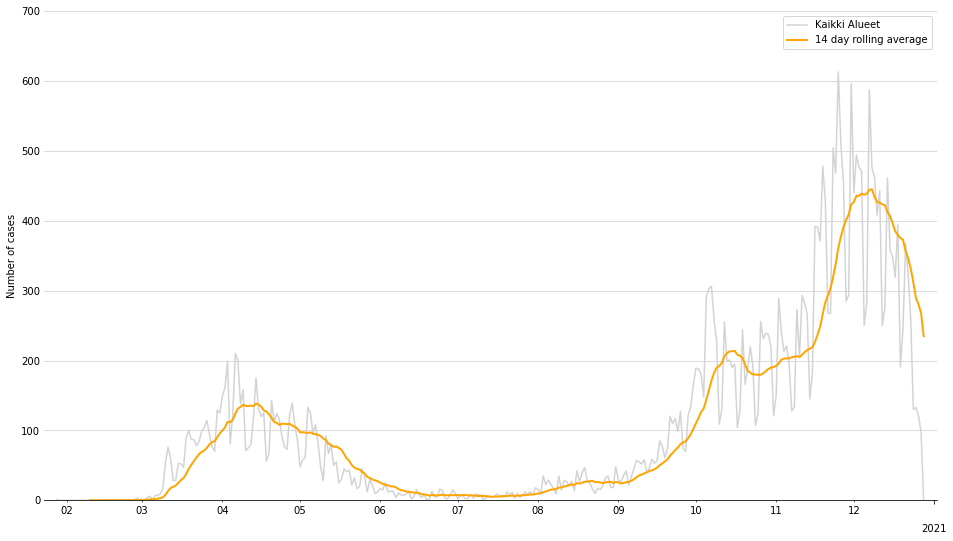

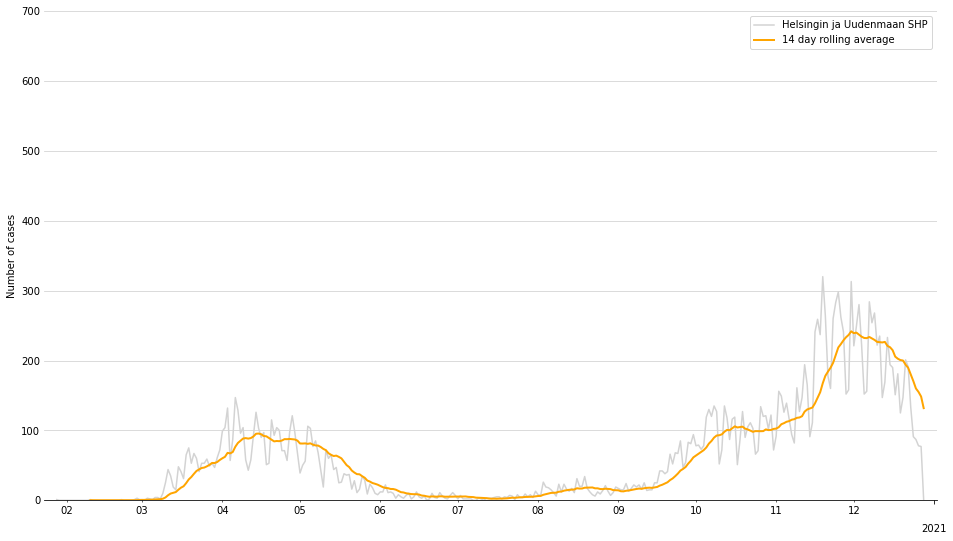

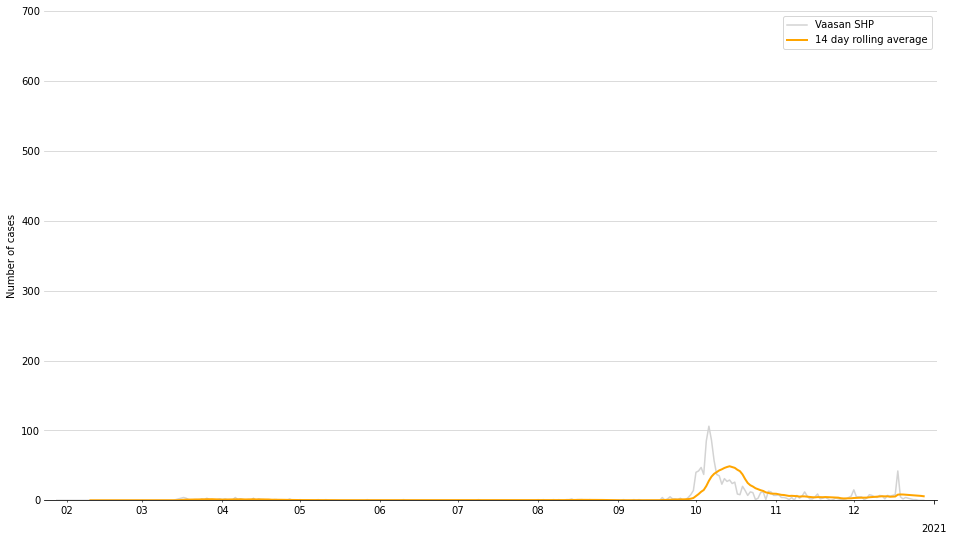

In [15]:
fig, ax = plt.subplots()

ax = df_dates.plot(y='Kaikki Alueet', label='Kaikki Alueet', color='lightgray', ax = ax)
ax = df_rolling14.plot(y='Kaikki Alueet', label='14 day rolling average', linewidth=2, color='orange', ax = ax)

ax.set_ylabel("Number of cases")
ax.xaxis.label.set_visible(False)
ax.set_ylim(0, 700)
ax.set_xlim(df_dates.first_valid_index() - pd.Timedelta(TIME_PADDING), df_dates.last_valid_index() + pd.Timedelta(TIME_PADDING))

remove_box(ax)
x_axis_style(ax, style='year_month')
y_axis_style(ax, style='gridline')

fig, ax = plt.subplots()

ax = df_dates.plot(y='Helsingin ja Uudenmaan SHP',label="Helsingin ja Uudenmaan SHP", color='lightgray', ax = ax)
ax = df_rolling14.plot(y='Helsingin ja Uudenmaan SHP', label='14 day rolling average', linewidth=2, color='orange', ax = ax)

ax.set_ylabel("Number of cases")
ax.xaxis.label.set_visible(False)
ax.set_ylim(0, 700)
ax.set_xlim(df_dates.first_valid_index() - pd.Timedelta(TIME_PADDING), df_dates.last_valid_index() + pd.Timedelta(TIME_PADDING))

remove_box(ax)
x_axis_style(ax, style='year_month')
y_axis_style(ax, style='gridline')

fig, ax = plt.subplots()

ax = df_dates.plot(y='Vaasan SHP', label='Vaasan SHP', color='lightgray', ax = ax)
ax = df_rolling14.plot(y='Vaasan SHP', label='14 day rolling average', linewidth=2, color='orange', ax = ax)

ax.set_ylabel("Number of cases")
ax.xaxis.label.set_visible(False)
ax.set_ylim(0, 700)
ax.set_xlim(df_dates.first_valid_index() - pd.Timedelta(TIME_PADDING), df_dates.last_valid_index() + pd.Timedelta(TIME_PADDING))

remove_box(ax)
x_axis_style(ax, style='year_month')
y_axis_style(ax, style='gridline')


## How is the number of cases changing?

How to find out wheter the number of cases is increaseing or decreasing, and if trend is changeing, when the change took place?

One idea is to create a rolling window that covers `n` days in the past and `n` days of future and see if what is the ratio oof the cases in the future compared to cases in the past.

If the ratio `future cases / past cases` is higher than one, it would mean that the cases are increasing. If the ratio is below one, then the number is decrasing.

To align the window to the mid day, it makes sense to have an uneven number of days. Two weeks seemst to be a popular statistic used in the newspapers. So let's take 14 day window to the past and future with the windows overlapping on the midpoint - the current day gets included both in past and future comparison.

### Create a rolling window

Let see how this would work. First create a new dataframe with the index

In [16]:
df_fb14 = df_rolling14.rolling(27, center=True).apply(lambda x: x.iloc[26] / x.iloc[13])

### Quick sanity check before we proceed

To verify the concept, lets select a random day, like October 5th here, and plot out the date

So we have 27 day window from September 22 to October 18: 13 days before Oct 5th, 13 days after Oct 5th. 

Let's create definitions for the different ranges:

In [17]:
mid_date = pd.Timestamp(2020,10,5)
start_date = mid_date + pd.Timedelta('- 13 days')
start_extended = start_date + pd.Timedelta('- 9 days')
end_date = mid_date + pd.Timedelta('13 days')
end_extended = end_date + pd.Timedelta('9 days')

date_ranges = [
    { 's': start_extended, 'e': end_extended, 'color': 'whitesmoke' },
    { 's': start_date, 'e': mid_date, 'color': 'sandybrown' },
    { 's': mid_date, 'e': end_date, 'color': 'lightsteelblue' },
    { 's': mid_date, 'e': mid_date, 'color': 'darkmagenta' }
]
print (start_date, ",", mid_date, ",", end_date)

2020-09-22 00:00:00 , 2020-10-05 00:00:00 , 2020-10-18 00:00:00



Let's compare the values from the above date ranges to rolling averege and window values to make sure the are correct

In [18]:
ref_ymid1 = df_dates.loc[start_date:mid_date,'Helsingin ja Uudenmaan SHP'].sum()
ref_ymid2 = df_rolling14.loc[mid_date,'Helsingin ja Uudenmaan SHP']

ref_yend1 = df_dates.loc[mid_date:end_date,'Helsingin ja Uudenmaan SHP'].sum()
ref_yend2 = df_rolling14.loc[end_date,'Helsingin ja Uudenmaan SHP']

ref = df_fb14.loc[mid_date,'Helsingin ja Uudenmaan SHP']

print('Window midpoint: sum of window {} vs rolling average {}, difference {}'.format(ref_ymid1/14, ref_ymid2, ref_ymid1/14 - ref_ymid2))
print('Window endpoint: sum of window {} vs rolling average {}, difference {}'.format(ref_yend1/14, ref_yend2, ref_yend1/14 - ref_yend2))
print('Window ratio: ratio of sum of window {} vs rolling {}, difference {}'.format(ref_yend1/ref_ymid1, ref, ref_yend1/ref_ymid1 - ref))


Window midpoint: sum of window 75.57142857142857 vs rolling average 75.57142857142857, difference 0.0
Window endpoint: sum of window 104.78571428571429 vs rolling average 104.78571428571429, difference 0.0
Window ratio: ratio of sum of window 1.386578449905482 vs rolling 1.386578449905482, difference 0.0


### Plot the case

We have had *1056* cases during the 14 days from Sept 22 to Oct 5, and *1466* cases from Oct 5 to Oct 18.

1056 cases in 14 days means *75.6* cases per day on avareage. 1466 cases means *104.7* cases per day on avarege.

The index would give the value *1.39* as 1466 / 1056, so the number of cases has inceased by about 40%.

The above results make sense, so let's plot out the time ranges.

Text(60, 60, '1.39')

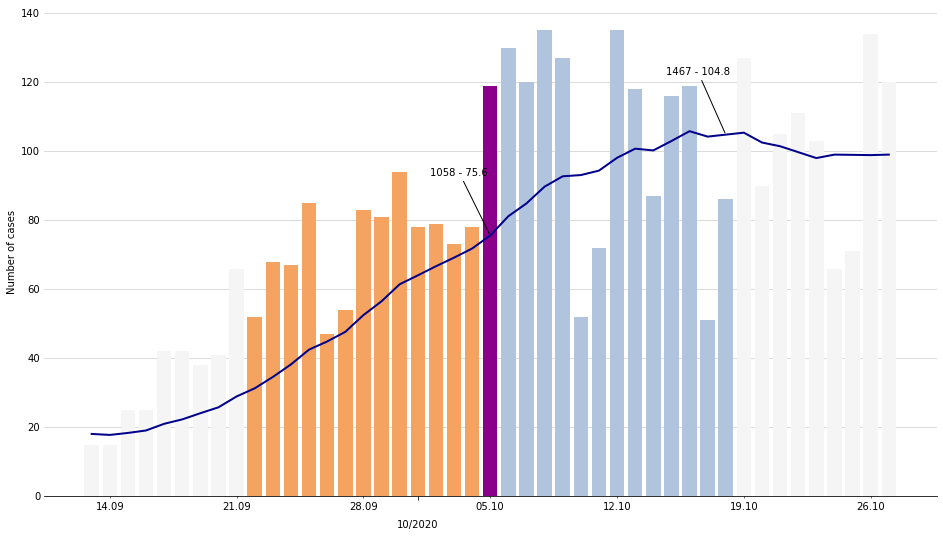

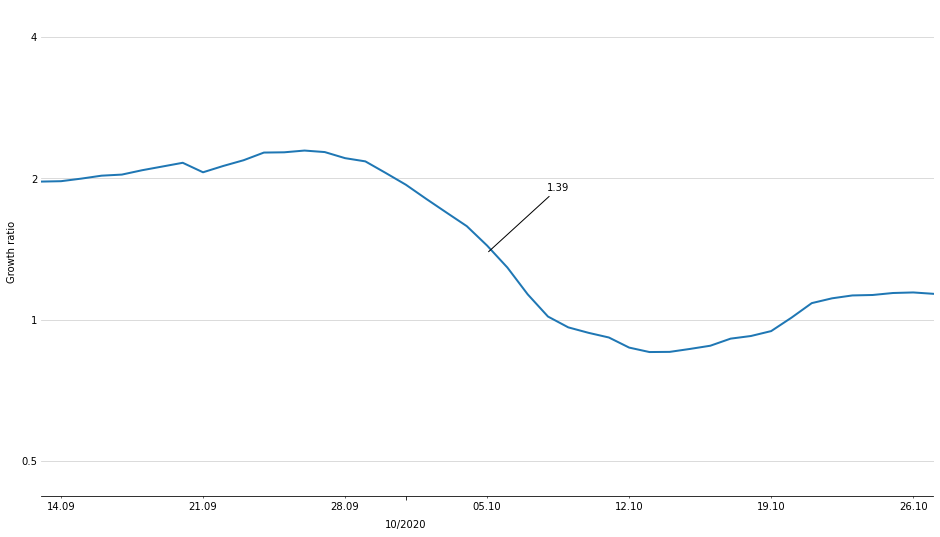

In [19]:
# First plot, days in each range as bars, with running 14- day averege overlaid

fig, ax = plt.subplots()

a = df_rolling14.loc[start_extended:end_extended,'Helsingin ja Uudenmaan SHP'].reset_index()
ax.plot(a['date'],a['Helsingin ja Uudenmaan SHP'], linewidth=2, color='darkblue')

for o in date_ranges:
    a = df_dates.loc[o['s']:o['e'],'Helsingin ja Uudenmaan SHP'].reset_index()
    ax.bar(x=a['date'], height=a['Helsingin ja Uudenmaan SHP'],color=o['color'])

remove_box(ax)
x_axis_style(ax,style='month_week')
y_axis_style(ax, style='gridline')

#ax.set_xlabel("Day")
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Number of cases")


text_offset = (-60,60)

ax.annotate('{:.0f} - {:.1f}'.format(ref_yend1,ref_yend2), xy=(end_date, ref_yend2), xytext=text_offset, textcoords='offset points',
            arrowprops=dict(color='black', arrowstyle='-'), fontsize=10)
ax.annotate('{:.0f} - {:.1f}'.format(ref_ymid1, ref_ymid2), (mid_date, ref_ymid2), xytext=text_offset, textcoords='offset points',
            arrowprops=dict(color='black', arrowstyle='-'), fontsize=10)

# Second plot, value of running ratio future and past 14 day windows

fig, ax = plt.subplots()

ax = df_fb14.loc[start_extended:end_extended].plot(y='Kaikki Alueet',logy=True, legend=False, linewidth=2, ax = ax)

remove_box(ax)
x_axis_style(ax,style='month_week')
y_axis_style(ax, style='gridline')

yticks = [ 2**j for j in range(-3,7) ]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.set_ylim(0.42, 4.64)

#ax.set_xlabel("Day")
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Growth ratio")

text_offset = (60,60)

ax.annotate('{:.2f}'.format(ref), xy=(mid_date, ref), xytext=text_offset, textcoords='offset points',
            va="bottom", ha="left",
            arrowprops=dict(color='black', arrowstyle='-'))

## What was the rate of change in the past?

Now that we have to tools, lets see what the history looks like. We'll select growth ratio for the capital area as well as for the whole country.

In [27]:
fig, ax = plt.subplots()

ax = df_fb14.plot(y='Helsingin ja Uudenmaan SHP',
                           label="Helsingin ja Uudenmaan SHP",
                           logy=True, ax=ax)
ax = df_fb14.plot(y='Kaikki Alueet',
                           label="Kaikki Alueet",
                           logy=True, ax=ax)

#ax.set_xlabel("Day")
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Growth ratio")

yticks = [ 2**j for j in range(-3,7) ]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_ylim(0.2, 4.8)
ax.set_xlim(df_dates.first_valid_index() - pd.Timedelta(TIME_PADDING), df_dates.last_valid_index() + pd.Timedelta(TIME_PADDING))


remove_box(ax)
x_axis_style(ax, style='year_month')
y_axis_style(ax, style='gridline')


### Changepoints

Hmm.. this seems to go up and down. Let's find out when have changes have taken place. We can record dates when the index has gone from above one to below one, or vice versa:

In [21]:
changepoints = df_fb14[['Kaikki Alueet']].copy()

changepoints['shifted'] = changepoints['Kaikki Alueet'].shift(1)

f = changepoints.apply(lambda x: (x['Kaikki Alueet'] < 1) & (x['shifted'] >= 1) | (x['Kaikki Alueet'] >= 1) & (x['shifted'] < 1),axis='columns')

changepoints = changepoints[f].drop(columns='shifted')

print(changepoints)

hcdmunicipality2020  Kaikki Alueet
date                              
2020-04-06                0.992507
2020-06-20                1.126316
2020-06-22                0.979798
2020-06-23                1.041667
2020-06-24                0.933333
2020-07-08                1.000000
2020-07-10                0.988764
2020-07-11                1.045977
2020-08-19                0.967568
2020-08-23                1.008219
2020-10-09                0.962726
2020-10-20                1.009583
2020-11-30                0.997300


Around midsummer and again in June the index has been hovering around one. Let's see what the index values look like first around first changepoint (April 5 to April 6) and then around June 22:

In [22]:
print(df_fb14.loc[pd.Timestamp(2020,4,1):pd.Timestamp(2020,4,9),'Kaikki Alueet'])
print(df_fb14.loc[pd.Timestamp(2020,6,16):pd.Timestamp(2020,6,28),'Kaikki Alueet'])

date
2020-04-01    1.384835
2020-04-02    1.313914
2020-04-03    1.194144
2020-04-04    1.151438
2020-04-05    1.104413
2020-04-06    0.992507
2020-04-07    0.901416
2020-04-08    0.837968
2020-04-09    0.811390
Name: Kaikki Alueet, dtype: float64
date
2020-06-16    0.708333
2020-06-17    0.845528
2020-06-18    0.857143
2020-06-19    0.952830
2020-06-20    1.126316
2020-06-21    1.028846
2020-06-22    0.979798
2020-06-23    1.041667
2020-06-24    0.933333
2020-06-25    0.827273
2020-06-26    0.850000
2020-06-27    0.890000
2020-06-28    0.852941
Name: Kaikki Alueet, dtype: float64


### Clean the adjacent changepoints
To plot the change points, it makes sense to clean the ones that are close to each other. Othervise the labels will overlap and obscure each other.

In [23]:
a = changepoints.reset_index()
f = a['date'] - a['date'].shift(1) > pd.Timedelta('5 days')
a[f]

hcdmunicipality2020       date  Kaikki Alueet
1                   2020-06-20       1.126316
5                   2020-07-08       1.000000
8                   2020-08-19       0.967568
10                  2020-10-09       0.962726
11                  2020-10-20       1.009583
12                  2020-11-30       0.997300

### Plot the points on top of the index

So we take the figure from the previous chart and add the change points on top of the index value for the whole country:

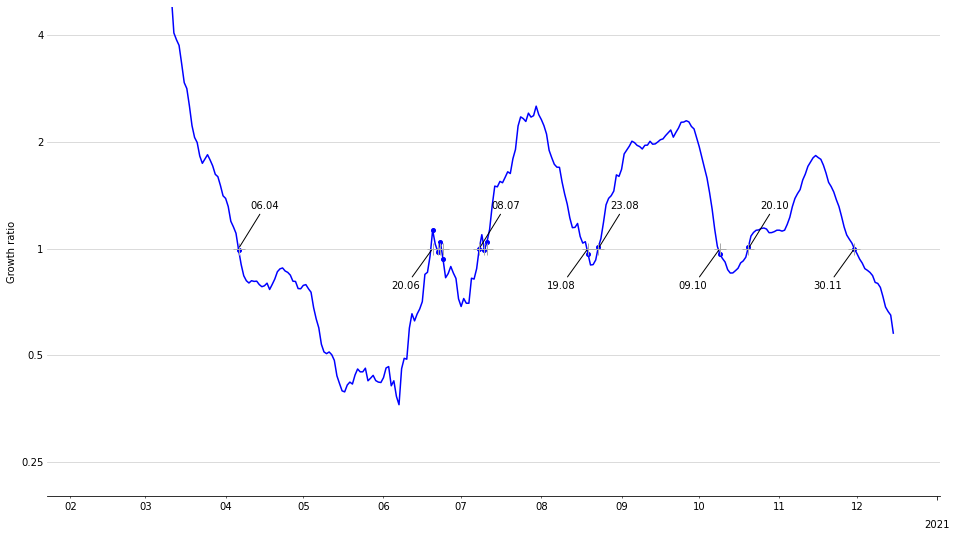

In [28]:
fig, ax = plt.subplots()

ax = df_fb14.plot(y='Kaikki Alueet',
                           label="Kaikki Alueet",
                           logy = True, color='blue', legend=False, ax = ax)
ax = changepoints.plot(y='Kaikki Alueet', logy = True, legend=False, linestyle='None', marker='o', color='blue', markersize = 4, ax = ax)

a = changepoints.reset_index()

ax.plot(a['date'],[1] * a.shape[0], marker='+',markersize = 12, linestyle='None', color='darkgrey')

#ax.set_xlabel("Day")
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Growth ratio")

yticks = [ 2**j for j in range(-3,7) ]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_ylim(0.2, 4.8)
ax.set_xlim(df_dates.first_valid_index() - pd.Timedelta(TIME_PADDING), df_dates.last_valid_index() + pd.Timedelta(TIME_PADDING))

remove_box(ax)
x_axis_style(ax, style='year_month')
y_axis_style(ax, style='gridline')

f = a['date'] - a['date'].shift(1) > pd.Timedelta('3 days')
f[0] = True
b = a[f]
n = 0
text_offset = -40

for d in b['date']:
    t = text_offset * ((n % 2) * 2 - 1) 
    
    ax.annotate(d.date().strftime("%d.%m"), xy=(d, 1), xytext= (t / 1.5, t), textcoords='offset points',
            ha="center", arrowprops=dict(color='black', arrowstyle='-'))
    n = n + 1

## Does this mean that the number of cases is now decreasing?

Probably yes. However, delay in reporting might distort the logic, though.

The numbers returned by the open data service do not seem to correspond to daily numbers published by the newspapers. 

On Dec 13, Helsingin Sanomat had the number of cases for the past 14 days as 6181, about 850 more than what is available in the open data set.

On Dec 19, the number reported by Helsingin Sanomat was 5635, about one thousand more than what is available.

If we assume that the HS reported number is correct, then adding the one thousand missing cases would yield a number that is slightly less than two weeks earlier.

Comparing daily reported cases, a week later about 325 cases have been added to past 5 days, Dec 8 to Dec 12, and, naturally, the 274 cases for Dec 13 that were not reported earlier.

In [25]:


# Dec 13: past 14 days

print(df_dates.loc[pd.Timestamp(2020,11,30):pd.Timestamp(2020,12,13),'Kaikki Alueet'])

print("Dec 13: total cases past 14 days",
      df_dates.loc[pd.Timestamp(2020,11,30):pd.Timestamp(2020,12,13),'Kaikki Alueet'].sum())

# Dec 13: one day before, past 14 days

print("Dec 13: total cases past 14 days, one day before", 
      df_dates.loc[pd.Timestamp(2020,11,29):pd.Timestamp(2020,12,12),'Kaikki Alueet'].sum())

# Dec 13: two days before, past 14 days

print("Dec 13: total cases past 14 days, two days before", 
      df_dates.loc[pd.Timestamp(2020,11,28):pd.Timestamp(2020,12,11),'Kaikki Alueet'].sum())

# Dec 19: past 14 days

print(df_dates.loc[pd.Timestamp(2020,12,6):pd.Timestamp(2020,12,19),'Kaikki Alueet'])

print("Dec 19: total cases past 14 days",
      df_dates.loc[pd.Timestamp(2020,12,6):pd.Timestamp(2020,12,19),'Kaikki Alueet'].sum())

# Dec 19: one day before, past 14 days

print("Dec 19: total cases past 14 days, one day before", 
      df_dates.loc[pd.Timestamp(2020,12,5):pd.Timestamp(2020,12,18),'Kaikki Alueet'].sum())

# Dec 19: two days before, past 14 days

print("Dec 19: total cases past 14 days, two days before", 
      df_dates.loc[pd.Timestamp(2020,12,4):pd.Timestamp(2020,12,17),'Kaikki Alueet'].sum())

date
2020-11-30    596.0
2020-12-01    440.0
2020-12-02    494.0
2020-12-03    477.0
2020-12-04    471.0
2020-12-05    250.0
2020-12-06    282.0
2020-12-07    587.0
2020-12-08    476.0
2020-12-09    462.0
2020-12-10    408.0
2020-12-11    443.0
2020-12-12    250.0
2020-12-13    275.0
Name: Kaikki Alueet, dtype: float64
Dec 13: total cases past 14 days 5911.0
Dec 13: total cases past 14 days, one day before 5929.0
Dec 13: total cases past 14 days, two days before 5964.0
date
2020-12-06    282.0
2020-12-07    587.0
2020-12-08    476.0
2020-12-09    462.0
2020-12-10    408.0
2020-12-11    443.0
2020-12-12    250.0
2020-12-13    275.0
2020-12-14    461.0
2020-12-15    358.0
2020-12-16    348.0
2020-12-17    319.0
2020-12-18    395.0
2020-12-19    191.0
Name: Kaikki Alueet, dtype: float64
Dec 19: total cases past 14 days 5255.0
Dec 19: total cases past 14 days, one day before 5314.0
Dec 19: total cases past 14 days, two days before 5390.0


## End of the data set

Looks like this 

In [37]:
df_dates.loc[df_dates.last_valid_index() - pd.Timedelta('30 days'):df_dates.last_valid_index(),'Kaikki Alueet']


date
2020-11-28    285.0
2020-11-29    293.0
2020-11-30    596.0
2020-12-01    440.0
2020-12-02    494.0
2020-12-03    477.0
2020-12-04    471.0
2020-12-05    250.0
2020-12-06    282.0
2020-12-07    587.0
2020-12-08    476.0
2020-12-09    462.0
2020-12-10    408.0
2020-12-11    443.0
2020-12-12    250.0
2020-12-13    275.0
2020-12-14    461.0
2020-12-15    358.0
2020-12-16    348.0
2020-12-17    319.0
2020-12-18    395.0
2020-12-19    191.0
2020-12-20    245.0
2020-12-21    367.0
2020-12-22    324.0
2020-12-23    259.0
2020-12-24    130.0
2020-12-25    133.0
2020-12-26    121.0
2020-12-27     97.0
2020-12-28      0.0
Name: Kaikki Alueet, dtype: float64